# Yolov8로 돌리기 위한 전처리 작업

# move image and txt file(from xml to txt)

xml to txt file
* file format: class_id center_x center_y width height (percentage)
* ref: https://roboflow.com/formats/yolov8-pytorch-txt tab: EXAMPLE


image and txt file directory path format
* ref: https://github.com/Balakishan77/Yolov8-Custom-Object-Detetction


train, validation split
1. dataframe으로 만들고, label 컬럼을 만들어서 해당하는 class_id를 넣어놓고
2. fast_ml의 train_valid_test_split 사용하기
3. 나눌 때 resize, padding 해서 저장하기.

In [1]:
from glob import glob
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from tqdm import tqdm

In [5]:
XML_PATH = '/Users/jeonminjeong/Downloads/해양 침적 쓰레기 이미지/Training/Training_labeling_underwater_photo'
TXT_PATH = '/Users/jeonminjeong/Downloads/underwater_images/'

cnt = 0
df = pd.DataFrame()


label2idx = {
    'tire' : 0,
    'spring fish trap' : 1, 'circular fish trap' : 1, 'rectangular fish trap' : 1, 'eel fish trap' : 1,
    'fish net' : 2,
    'wood' : 3,
    'bundle of ropes' : 4, 'bundle of rope' : 4, 'rope' : 4, 
    'other objects' : 5, 'other objets': 5, 'othe objects': 5
    }
 
for xml_file in tqdm(glob(XML_PATH + '/*.xml')): 
    
    filename = f'{TXT_PATH}' + xml_file.split('/')[-1][:-4] + '.txt'
    f = open(filename, 'w')

    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    fname = root.find('filename').text
    for member in root.findall('object'):
        try:
            bbx = member.find('bndbox')
            label = member.find('name').text

            img_width = float(root.find('size')[0].text)
            img_height = float(root.find('size')[1].text)

            xmin = float(bbx.find('xmin').text)
            ymin = float(bbx.find('ymin').text)
            xmax = float(bbx.find('xmax').text)
            ymax = float(bbx.find('ymax').text)
            width = float(bbx.find('width').text) # 
            height = float(bbx.find('height').text) #
            
            label_idx = label2idx[label] 
            x, y = (xmin + xmax)/2/img_width, (ymin + ymax)/2/img_height # center-x, center-y
            w = width / img_width # width
            h = height / img_height # height

            info = f'{label_idx} {x} {y} {w} {h}'
            
            if label_idx != 5:
                f.write(info+'\n')
        except:
            print(xml_file)
            
    if label_idx != 5:
        cnt += 1
        new_row = {'cls_id': label_idx, 'name': fname}
        df = df.append(new_row, ignore_index=True)
    
print('total: ', cnt)

  0%|          | 0/9023 [00:00<?, ?it/s]/var/folders/p4/l6qy0qkd2jd9ptr7xxhfl6cc0000gn/T/ipykernel_4143/3418721082.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/var/folders/p4/l6qy0qkd2jd9ptr7xxhfl6cc0000gn/T/ipykernel_4143/3418721082.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/var/folders/p4/l6qy0qkd2jd9ptr7xxhfl6cc0000gn/T/ipykernel_4143/3418721082.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/var/folders/p4/l6qy0qkd2jd9ptr7xxhfl6cc0000gn/T/ipykernel_4143/3418721082.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

total:  9009


In [6]:
df

,cls_id,name
0,3,wood_048_01220.jpg
1,4,circular fish trap_rope_047_03288.jpg
2,3,wood_048_02729.jpg
3,4,tire_bundle of ropes_042_05398.jpg
4,1,eel fish trap_047_02574.jpg
...,...,...
9004,3,wood_042_01504.jpg
9005,0,tire_044_01433.jpg
9006,0,bundle of ropes_tire_004_01712.jpg
9007,0,tire_029_00862.jpg


In [26]:
!pip install fast_ml 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.2 MB/s eta 0:00:00


In [7]:
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'cls_id', method='random', sort_by_col='cls_id',
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)


print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(7207, 1) (7207,) (901, 1) (901,) (901, 1) (901,)


In [8]:
y_train.groupby(y_train).count()

cls_id
0    1602
1    2032
2     522
3    1382
4    1669
Name: cls_id, dtype: int64

In [9]:
df.groupby('cls_id').count()

,name
cls_id,
0,2003
1,2551
2,650
3,1715
4,2090


In [10]:
X_train

,name
7894,wood_042_07407.jpg
217,tire_044_01238.jpg
4528,spring fish trap_046_03114.jpg
6534,spring fish trap_046_03919.jpg
6153,spring fish trap_046_02999.jpg
...,...
5799,tire_046_02656.jpg
7030,tire_042_08830.jpg
6001,tire_046_03993.jpg
8877,bundle of ropes_circular fish trap_044_04330.jpg


In [89]:
for i in X_train["name"]:
    print(i)
    break

rectangular fish trap_bundle of ropes_047_01634.jpg


In [11]:
import os
import shutil

TRAIN_PATH = '/Users/jeonminjeong/Downloads/underwater_images/train/labels/'
VALID_PATH = '/Users/jeonminjeong/Downloads/underwater_images/valid/labels/'

# move txt file
# train
for i in tqdm(X_train["name"]):
    i = i.split('.')[0] + ".txt"
    shutil.move(TXT_PATH + i, TRAIN_PATH + i)
# valid, test
for i in tqdm(X_valid["name"]):
    i = i.split('.')[0] + ".txt"
    shutil.move(TXT_PATH + i, VALID_PATH + i)
for i in tqdm(X_test["name"]):
    i = i.split('.')[0] + ".txt"
    shutil.move(TXT_PATH + i, VALID_PATH + i)

100%|██████████| 901/901 [00:00<00:00, 14314.33it/s]


14 개의 경우 other objects와 같이 있는 사진이라 삭제함.

0, 1, 2, 3, 4 라벨만 사용. other objects 인 5는 제거.

9023 - 14 = 9009

In [ ]:
# move img file
# 1920 x 1080 -> 640 x 640
import cv2


def SetImageResizeNPadding(image_path, save_image_path, targetWidth, targetHeight, finalTargetSize):
    # 이미지 받을 경로, 저장할 경로, 중간 너비, 중간 높이, 최종 크기(정사각형이므로 길이하나만)
    # load image
    imageToPredict = cv2.imread(image_path, 3) # 단일 이미지 읽기
    img = np.array(imageToPredict); # 이미지 행렬화

    # resize
    img = cv2.resize(imageToPredict, (targetWidth, targetHeight)); # 이미지 리사이즈
    img = np.array(img); # resize 된 이미지 행렬화

    # padding
    y_zero, x_zero, target_height, target_width = (0, 0, img.shape[0], img.shape[1]) # 바뀐 이미지의 패딩계산을 위한 크기

    # 그림 주변에 검은색으로 칠하기
    padding_width = (finalTargetSize - (target_width - x_zero))/2  # w_x = (targetWidth - 그림)을 뺀 나머지 영역 크기 [ 그림나머지/2 [그림] 그림나머지/2 ]
    padding_height = (finalTargetSize - (target_height - y_zero))/2

    if(padding_width < 0):         # 크기가 -면 0으로 지정.
        padding_width = 0
    elif(padding_height < 0):
        padding_height = 0

    M = np.float32([[1, 0, padding_width], [0, 1, padding_height]])  #(2*3 이차원 행렬)
    img_re = cv2.warpAffine(img, M, (finalTargetSize, finalTargetSize)) # 패딩 실행

    # save image
    cv2.imwrite(save_image_path, img_re) # 저장
    
    
# train
TRAIN_IMAGE_PATH = '/Users/jeonminjeong/Downloads/underwater_images/train/images/'
TRAIN_LABEL_PATH = '/Users/jeonminjeong/Downloads/underwater_images/train/labels/'
ORIGINAL_IMAGE_PATH = '/Users/jeonminjeong/Downloads/해양 침적 쓰레기 이미지/Training/Training_underwater_photo/'

# 1920 x 1080 = 640 x 360
for file in tqdm(glob(TRAIN_LABEL_PATH + '*.txt')):
    source = ORIGINAL_IMAGE_PATH + file.split('/')[-1].split('.')[0] + '.jpg'
    destination = TRAIN_IMAGE_PATH + file.split('/')[-1].split('.')[0] + '.jpg'
    # print(source)
    SetImageResizeNPadding(source, destination, 640, 360, 640)
# 7207

In [ ]:
# valid, text
VALID_IMAGE_PATH = '/Users/jeonminjeong/Downloads/underwater_images/valid/images/'
VALID_LABEL_PATH = '/Users/jeonminjeong/Downloads/underwater_images/valid/labels/'

# 1920 x 1080 = 640 x 360
for file in tqdm(glob(VALID_LABEL_PATH + '*.txt')):
    source = ORIGINAL_IMAGE_PATH + file.split('/')[-1].split('.')[0] + '.jpg'
    destination = VALID_IMAGE_PATH + file.split('/')[-1].split('.')[0] + '.jpg'
    # print(source)
    SetImageResizeNPadding(source, destination, 640, 360, 640)
    
# 라벨링이 일치하지 않는, 제대로 되지 않은 eel fish trap_004_02882 삭제: 타이어, fish trap이 있는데 tire가 라벨에 없음.
# 1801
# total 9008

folder template

ref: https://medium.com/augmented-startups/train-yolov8-on-custom-data-6d28cd348262

├── yolov8

 -----└── train

 -------└── images (folder including all training images)

 -------└── labels (folder including all training labels)

 -----└── test

 -------└── images (folder including all testing images)

 -------└── labels (folder including all testing labels)

 -----└── valid

 -------└── images (folder including all testing images)

 -------└── labels (folder including all testing labels)



 underwater.yaml 까지 만들어줍니다.

# Augmentation

In [1]:
# install albumentation
!pip install -U albumentations

  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)
  Using cached scikit_image-0.20.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.4 MB)
  Using cached opencv_python_headless-4.7.0.72-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.2 MB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  Using cached scipy-1.9.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.4/219.4 kB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 82.0 MB/s eta 0:00:00:00:01
  Using cached PyWavelets-1.4.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.9 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [2]:
import albumentations as A
import cv2
from matplotlib import pyplot as plt

In [20]:
transform = A.Compose([
    A.HorizontalFlip(p=0.8),
    A.RandomBrightnessContrast(p=0.7),
], bbox_params=A.BboxParams(format='yolo'))

In [10]:
image = cv2.imread("/home/cubox/Documents/ummjevel/underwater/underwater_images/train/images/bundle of ropes_002_00012.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [14]:
# 4 0.44720460757155406 0.3428531004546065 0.3900370810648717 0.2917282792686845
# 4 0.47597051933500156 0.20624472397134985 0.4416285452974663 0.04808593885975909
bboxes = []
with open('/home/cubox/Documents/ummjevel/underwater/underwater_images/train/labels/bundle of ropes_002_00012.txt', 'r') as f:
    for line in f.readlines():
        temp = line.strip().split(" ")
        bboxes.append(list(map(float, temp[1:])) + [int(temp[0])])

print(bboxes)

[[0.44720460757155406, 0.3428531004546065, 0.3900370810648717, 0.2917282792686845, 4], [0.47597051933500156, 0.20624472397134985, 0.4416285452974663, 0.04808593885975909, 4]]


In [21]:
transformed = transform(image=image, bboxes=bboxes)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']

In [22]:
print(bboxes)
print(transformed_bboxes)

[[0.44720460757155406, 0.3428531004546065, 0.3900370810648717, 0.2917282792686845, 4], [0.47597051933500156, 0.20624472397134985, 0.4416285452974663, 0.04808593885975909, 4]]
[(0.5527953924284459, 0.3428531004546065, 0.3900370810648718, 0.2917282792686845, 4), (0.5240294806649984, 0.20624472397134985, 0.4416285452974662, 0.04808593885975909, 4)]


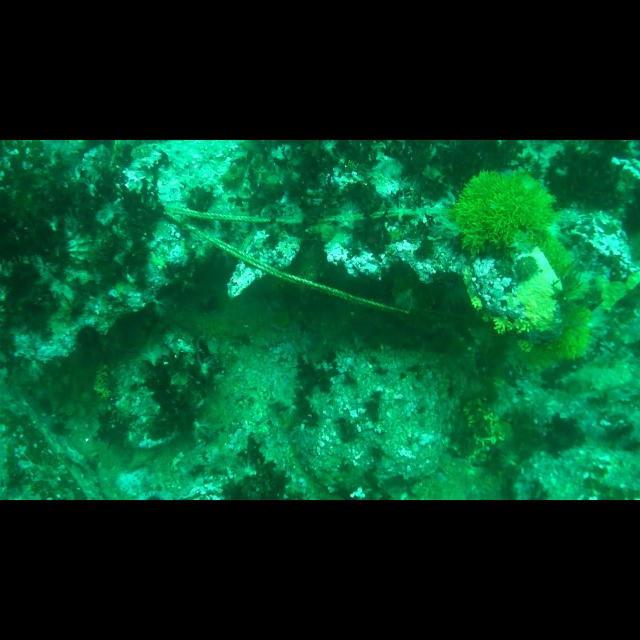

In [18]:
from PIL import Image
import cv2 
from IPython.display import display

display(Image.fromarray(image))

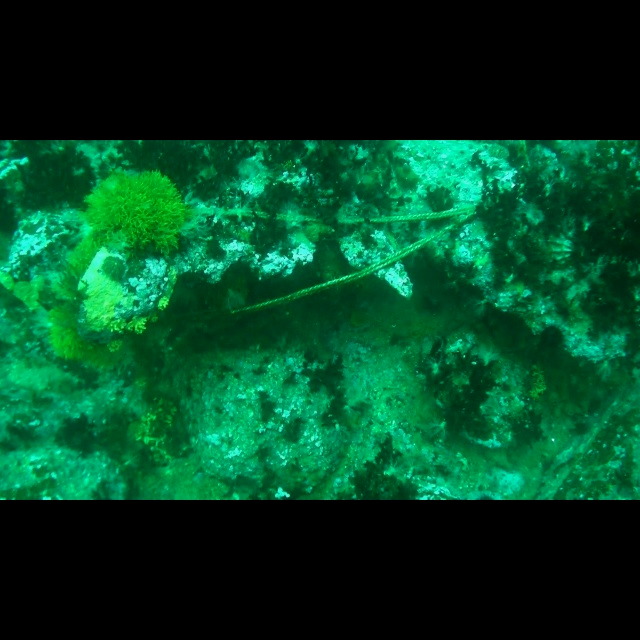

In [23]:
display(Image.fromarray(transformed_image))

In [2]:
# 폴더 복사 train -> train_aug, val은 그대로.
!cp -r /home/cubox/Documents/ummjevel/underwater/underwater_images/train /home/cubox/Documents/ummjevel/underwater/underwater_images/train_aug

In [24]:
from PIL import Image
import cv2 
from IPython.display import display
import glob
import pandas as pd
from tqdm import tqdm
import albumentations as A
from matplotlib import pyplot as plt

In [31]:
# 필요한 갯수에 비율별로 나눠서 하기.
# /home/cubox/Documents/ummjevel/underwater/underwater_images/train/labels
# 경로에서 txt 파일 읽어서 클래스별 개수 찾기

dict_labels = {}
LABELS_PATH = '/home/cubox/Documents/ummjevel/underwater/underwater_images/train/labels'

for file in glob.glob(LABELS_PATH + '/*.txt'):
    with open(file, 'r') as f:
        for line in f.readlines():
            current_label = line.split(" ")[0]
            if current_label not in dict_labels:
                dict_labels[current_label] = 1
            else:
                dict_labels[current_label] += 1

print(dict_labels)

{'0': 1949, '3': 1526, '4': 2201, '1': 2811, '2': 595}


참고: https://tugot17.github.io/data-science-blog/albumentations/data-augmentation/tutorial/2020/09/20/Pixel-level-transforms-using-albumentations-package.html

In [25]:
transform = A.Compose([
    A.OneOf([
        A.HorizontalFlip(p=1),
        A.RandomRotate90(p=1),
        A.VerticalFlip(p=1),
        A.GaussNoise(p=1),
        A.HueSaturationValue(50, 50, 20,  p=1.0),
        A.RGBShift(50, 50, 50,  p=1.0),
        A.RandomBrightnessContrast(0.5, 0.2, True,  p=1.0),
        A.RandomFog(0.3, 0.5, 0.08,  p=1.0),
        A.RandomGamma((80, 200),  p=1.0),
        A.CLAHE(6.0, (10, 10), p=1.0)
    ], p=1),
], bbox_params=A.BboxParams(format='yolo'))

In [51]:
# 읽어서 음수 나오는 것 확인하기.
for file in glob.glob(LABEL_PATH2 + '/*.txt'):
    with open(file, 'r') as f:
        for line in f.readlines():
            if '-' in str(line):
                print(file)

In [44]:
LABEL_PATH = '/home/cubox/Documents/ummjevel/underwater/underwater_images/train_aug/labels/'
IMAGE_PATH = '/home/cubox/Documents/ummjevel/underwater/underwater_images/train_aug/images/'
SAVE_PATH = '/home/cubox/Documents/ummjevel/underwater/underwater_images/train_aug/'
LABEL_PATH2 = '/home/cubox/Documents/ummjevel/underwater/underwater_images/train/labels/'

In [45]:
print(LABEL_PATH)

/home/cubox/Documents/ummjevel/underwater/underwater_images/train_aug/labels/


In [42]:
print(dict_labels)

{'0': 1949, '3': 1526, '4': 2201, '1': 2811, '2': 595}


In [46]:
# 2800 개로 맞추기

# text 파일 순서대로 열어서 라벨 확인한 다음에
# 라벨마다 필요한 개수에 해당되면 augmentation 하고,
# 갯수 다 채웠을 경우 skip.
# 파일명은 aug_ 로 시작

error_list = []
print('start!')
print(dict_labels)

for file in tqdm(sorted(glob.glob(LABEL_PATH2 + '*.txt'))):
    try:
        with open(file, 'r') as f:
            bboxes = []
            for line in f.readlines():
                temp = line.strip().split(" ")
                bboxes.append(list(map(float, temp[1:])) + [int(temp[0])])
            
            for bbox in bboxes:
                
                if dict_labels[str(bbox[-1])] <= 2800:
                    # get image
                    image = cv2.imread(IMAGE_PATH + file.split("/")[-1].split(".")[0] + ".jpg")
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    # display(Image.fromarray(image))
                    # augmentation
                    transformed = transform(image=image, bboxes=bboxes)
                    transformed_image = transformed['image']
                    transformed_bboxes = transformed['bboxes'] 
                    # display(Image.fromarray(image))
                    # display(Image.fromarray(transformed_image))
                    # save image, txt
                    image_name = f'{IMAGE_PATH}aug_{file.split("/")[-1].split(".")[0]}_{str(bbox[-1])}-{dict_labels[str(bbox[-1])]+1}.jpg'
                    txt_name = f'{LABEL_PATH}aug_{file.split("/")[-1].split(".")[0]}_{str(bbox[-1])}-{dict_labels[str(bbox[-1])]+1}.txt'
                    
                    cv2.imwrite(image_name, transformed_image)
                    with open(txt_name, 'w') as f:
                        for tbbox in transformed_bboxes:
                            f.write(' '.join(list(map(str, [tbbox[-1]] + list(tbbox[0:-1])))))
                            f.write('\n')
                    # bboxes에 있는 모든 클래스 다 추가하기.
                    for tpbox in bboxes:
                        dict_labels[str(tpbox[-1])] += 1
    except Exception as e:
        error_list.append(file)
        print(str(e))
            
print("done!")
print(dict_labels)

start!
{'0': 1949, '3': 1526, '4': 2201, '1': 2811, '2': 595}


  0%|          | 18/7207 [00:00<02:06, 56.75it/s]

In YOLO format all coordinates must be float and in range (0, 1]


  1%|          | 59/7207 [00:01<02:03, 57.77it/s]

In YOLO format all coordinates must be float and in range (0, 1]
In YOLO format all coordinates must be float and in range (0, 1]


  1%|          | 72/7207 [00:01<02:16, 52.16it/s]

In YOLO format all coordinates must be float and in range (0, 1]
In YOLO format all coordinates must be float and in range (0, 1]


  1%|          | 87/7207 [00:01<02:11, 54.32it/s]

In YOLO format all coordinates must be float and in range (0, 1]


  1%|▏         | 102/7207 [00:01<01:57, 60.33it/s]

In YOLO format all coordinates must be float and in range (0, 1]


  2%|▏         | 150/7207 [00:02<02:22, 49.68it/s]

In YOLO format all coordinates must be float and in range (0, 1]


  2%|▏         | 180/7207 [00:03<02:20, 49.87it/s]

In YOLO format all coordinates must be float and in range (0, 1]


  3%|▎         | 196/7207 [00:03<02:00, 57.98it/s]

Expected y_min for bbox (0.2406005859375, -0.004014756944444475, 0.7801513671875, 0.8531901041666667, 4) to be in the range [0.0, 1.0], got -0.004014756944444475.
In YOLO format all coordinates must be float and in range (0, 1]
In YOLO format all coordinates must be float and in range (0, 1]


  4%|▍         | 279/7207 [00:05<02:14, 51.48it/s]

In YOLO format all coordinates must be float and in range (0, 1]


  5%|▍         | 360/7207 [00:06<01:44, 65.25it/s]

In YOLO format all coordinates must be float and in range (0, 1]


  6%|▌         | 430/7207 [00:08<02:50, 39.77it/s]

Expected x_min for bbox (-0.00048828125, 0.39713541666666663, 0.32275390625, 0.7495659722222222, 4) to be in the range [0.0, 1.0], got -0.00048828125.


  7%|▋         | 478/7207 [00:08<01:09, 96.31it/s] 

Expected y_min for bbox (0.0526123046875, -0.010525173611111105, 0.5750732421875, 0.9725477430555556, 4) to be in the range [0.0, 1.0], got -0.010525173611111105.
Expected x_min for bbox (-0.0010986328124999722, 0.4886067708333333, 0.2601318359375, 1.0, 4) to be in the range [0.0, 1.0], got -0.0010986328124999722.


 26%|██▌       | 1878/7207 [00:09<00:02, 2488.17it/s]

Expected x_min for bbox (-0.00048828125, 0.7026909722222223, 0.45361328125, 1.0, 1) to be in the range [0.0, 1.0], got -0.00048828125.
Expected y_min for bbox (0.03173828125, -0.0004340277777777901, 0.53857421875, 0.5325520833333334, 2) to be in the range [0.0, 1.0], got -0.0004340277777777901.
Expected y_min for bbox (0.0, -0.0004340277777777901, 0.77978515625, 0.65234375, 2) to be in the range [0.0, 1.0], got -0.0004340277777777901.
In YOLO format all coordinates must be float and in range (0, 1]
In YOLO format all coordinates must be float and in range (0, 1]
In YOLO format all coordinates must be float and in range (0, 1]
In YOLO format all coordinates must be float and in range (0, 1]
In YOLO format all coordinates must be float and in range (0, 1]
In YOLO format all coordinates must be float and in range (0, 1]
In YOLO format all coordinates must be float and in range (0, 1]
Expected y_min for bbox (0.2772216796875, -0.008355034722222224, 0.6190185546875, 0.07628038194444445, 2) 

 30%|███       | 2178/7207 [00:14<00:25, 200.70it/s] 

Expected x_min for bbox (-0.0010986328125, 0.1283637152777778, 0.4285888671875, 0.6969401041666666, 2) to be in the range [0.0, 1.0], got -0.0010986328125.
Expected y_min for bbox (0.0, -0.0004340277777777901, 0.38037109375, 0.4040798611111111, 2) to be in the range [0.0, 1.0], got -0.0004340277777777901.


 42%|████▏     | 3022/7207 [00:18<00:16, 246.62it/s]

In YOLO format all coordinates must be float and in range (0, 1]
Expected y_min for bbox (0.49853515625, -0.0004340277777777901, 0.71728515625, 0.4839409722222222, 4) to be in the range [0.0, 1.0], got -0.0004340277777777901.


 54%|█████▍    | 3914/7207 [00:19<00:07, 458.17it/s]

In YOLO format all coordinates must be float and in range (0, 1]
Expected x_min for bbox (-0.0010986328125, 0.22819010416666669, 0.6983642578125, 1.0, 0) to be in the range [0.0, 1.0], got -0.0010986328125.
Expected x_min for bbox (-0.0010172526041666852, 0.05049050564236118, 0.8949788411458333, 0.7861675889756945, 0) to be in the range [0.0, 1.0], got -0.0010172526041666852.


 58%|█████▊    | 4196/7207 [00:22<00:12, 236.01it/s]

Expected y_min for bbox (0.2151692509651184, -0.0015914440155029297, 0.8977864384651184, 0.7900752226511637, 0) to be in the range [0.0, 1.0], got -0.0015914440155029297.
Expected y_min for bbox (0.29443359375, -0.0004340277777777901, 0.80419921875, 0.5325520833333334, 0) to be in the range [0.0, 1.0], got -0.0004340277777777901.


 61%|██████    | 4396/7207 [00:25<00:18, 155.07it/s]

Expected y_min for bbox (0.11669921875, -0.0004340277777777901, 0.83837890625, 0.7200520833333334, 0) to be in the range [0.0, 1.0], got -0.0004340277777777901.
In YOLO format all coordinates must be float and in range (0, 1]


 78%|███████▊  | 5641/7207 [00:30<00:04, 349.78it/s]

Expected x_min for bbox (-0.00048828125, 0.15407986111111116, 0.84423828125, 1.0, 3) to be in the range [0.0, 1.0], got -0.00048828125.


 89%|████████▊ | 6390/7207 [00:42<00:09, 86.68it/s] 

In YOLO format all coordinates must be float and in range (0, 1]


 92%|█████████▏| 6621/7207 [00:47<00:12, 45.47it/s]

Expected x_min for bbox (-0.0010986328125, 0.36490885416666663, 0.9217529296875, 0.7034505208333333, 3) to be in the range [0.0, 1.0], got -0.0010986328125.


 94%|█████████▎| 6745/7207 [00:49<00:09, 49.64it/s]

Expected y_min for bbox (0.1246337890625, -0.0018446180555555802, 0.8131103515625, 0.8314887152777778, 3) to be in the range [0.0, 1.0], got -0.0018446180555555802.


100%|██████████| 7207/7207 [00:50<00:00, 141.86it/s]

done!
{'0': 2848, '3': 2823, '4': 2997, '1': 2937, '2': 1296}


In [27]:
print(len(error_list))

43


2 fish_net 이 1296 개라서 2800개 채울 때까지만 다시 랜덤으로 해서 해보겠습니다.

In [48]:
# aug 이름에서 fish_net 중에 가장 뒤에 숫자가 높은 것을 찾는다.
# 595에서 시작
# 1296에서 마침
# 순수하게 fish_net 만 있는 것은 503개. 이것을 가지고 한다.
fish_error_list = []
# aug 폴더가 원본임.
FOLDER_PATH = '/home/cubox/Documents/ummjevel/underwater/underwater_images/train_aug/labels/fish net*'
# print(len(glob.glob(FOLDER_PATH)))

print("start!")
print(dict_labels)

for _ in range(3):
    for file in tqdm(sorted(glob.glob(FOLDER_PATH))):
        try:
            with open(file, 'r') as f:
                bboxes = []
                for line in f.readlines():
                    temp = line.strip().split(" ")
                    bboxes.append(list(map(float, temp[1:])) + [int(temp[0])])
                
                for bbox in bboxes:
                    
                    if dict_labels[str(bbox[-1])] <= 2800:
                        # get image
                        image = cv2.imread(IMAGE_PATH + file.split("/")[-1].split(".")[0] + ".jpg")
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        # display(Image.fromarray(image))
                        # augmentation
                        transformed = transform(image=image, bboxes=bboxes)
                        transformed_image = transformed['image']
                        transformed_bboxes = transformed['bboxes'] 
                        # display(Image.fromarray(image))
                        # display(Image.fromarray(transformed_image))
                        # save image, txt
                        image_name = f'{IMAGE_PATH}aug_{file.split("/")[-1].split(".")[0]}_{str(bbox[-1])}-{dict_labels[str(bbox[-1])]+1}.jpg'
                        txt_name = f'{LABEL_PATH}aug_{file.split("/")[-1].split(".")[0]}_{str(bbox[-1])}-{dict_labels[str(bbox[-1])]+1}.txt'
                        
                        cv2.imwrite(image_name, transformed_image)
                        with open(txt_name, 'w') as f:
                            for tbbox in transformed_bboxes:
                                f.write(' '.join(list(map(str, [tbbox[-1]] + list(tbbox[0:-1])))))
                                f.write('\n')
                        # bboxes에 있는 모든 클래스 다 추가하기.
                        for tpbox in bboxes:
                            dict_labels[str(tpbox[-1])] += 1
        except Exception as e:
            fish_error_list.append(file)
            print(str(e))
            
print("done!")
print(dict_labels)

start!
{'0': 2848, '3': 2823, '4': 2997, '1': 2937, '2': 1296}


  5%|▍         | 23/503 [00:00<00:07, 61.07it/s]

Expected y_min for bbox (0.03173828125, -0.0004340277777777901, 0.53857421875, 0.5325520833333334, 2) to be in the range [0.0, 1.0], got -0.0004340277777777901.


 10%|▉         | 49/503 [00:00<00:06, 72.84it/s]

Expected y_min for bbox (0.0, -0.0004340277777777901, 0.77978515625, 0.65234375, 2) to be in the range [0.0, 1.0], got -0.0004340277777777901.
In YOLO format all coordinates must be float and in range (0, 1]


 21%|██        | 106/503 [00:01<00:06, 66.04it/s]

In YOLO format all coordinates must be float and in range (0, 1]


 26%|██▌       | 130/503 [00:02<00:06, 58.90it/s]

In YOLO format all coordinates must be float and in range (0, 1]


 29%|██▊       | 144/503 [00:02<00:05, 61.72it/s]

In YOLO format all coordinates must be float and in range (0, 1]


 36%|███▌      | 182/503 [00:02<00:05, 59.67it/s]

In YOLO format all coordinates must be float and in range (0, 1]
In YOLO format all coordinates must be float and in range (0, 1]


 42%|████▏     | 213/503 [00:03<00:05, 52.15it/s]

In YOLO format all coordinates must be float and in range (0, 1]
Expected y_min for bbox (0.2772216796875, -0.008355034722222224, 0.6190185546875, 0.07628038194444445, 2) to be in the range [0.0, 1.0], got -0.008355034722222224.


 93%|█████████▎| 470/503 [00:08<00:00, 50.86it/s]

Expected x_min for bbox (-0.0010986328125, 0.1283637152777778, 0.4285888671875, 0.6969401041666666, 2) to be in the range [0.0, 1.0], got -0.0010986328125.


 99%|█████████▉| 499/503 [00:09<00:00, 56.24it/s]

Expected y_min for bbox (0.0, -0.0004340277777777901, 0.38037109375, 0.4040798611111111, 2) to be in the range [0.0, 1.0], got -0.0004340277777777901.


  5%|▍         | 23/503 [00:00<00:07, 63.99it/s]

Expected y_min for bbox (0.03173828125, -0.0004340277777777901, 0.53857421875, 0.5325520833333334, 2) to be in the range [0.0, 1.0], got -0.0004340277777777901.


  7%|▋         | 37/503 [00:00<00:07, 60.69it/s]

Expected y_min for bbox (0.0, -0.0004340277777777901, 0.77978515625, 0.65234375, 2) to be in the range [0.0, 1.0], got -0.0004340277777777901.
In YOLO format all coordinates must be float and in range (0, 1]


 20%|██        | 103/503 [00:01<00:04, 80.06it/s]

In YOLO format all coordinates must be float and in range (0, 1]


 25%|██▌       | 127/503 [00:02<00:06, 58.39it/s]

In YOLO format all coordinates must be float and in range (0, 1]


 29%|██▉       | 146/503 [00:02<00:06, 54.05it/s]

In YOLO format all coordinates must be float and in range (0, 1]


 36%|███▋      | 183/503 [00:03<00:05, 54.73it/s]

In YOLO format all coordinates must be float and in range (0, 1]
In YOLO format all coordinates must be float and in range (0, 1]


 42%|████▏     | 210/503 [00:03<00:06, 46.41it/s]

In YOLO format all coordinates must be float and in range (0, 1]
Expected y_min for bbox (0.2772216796875, -0.008355034722222224, 0.6190185546875, 0.07628038194444445, 2) to be in the range [0.0, 1.0], got -0.008355034722222224.


 93%|█████████▎| 470/503 [00:08<00:00, 66.85it/s]

Expected x_min for bbox (-0.0010986328125, 0.1283637152777778, 0.4285888671875, 0.6969401041666666, 2) to be in the range [0.0, 1.0], got -0.0010986328125.


 99%|█████████▉| 499/503 [00:09<00:00, 52.57it/s]

Expected y_min for bbox (0.0, -0.0004340277777777901, 0.38037109375, 0.4040798611111111, 2) to be in the range [0.0, 1.0], got -0.0004340277777777901.


  4%|▍         | 21/503 [00:00<00:08, 56.20it/s]

Expected y_min for bbox (0.03173828125, -0.0004340277777777901, 0.53857421875, 0.5325520833333334, 2) to be in the range [0.0, 1.0], got -0.0004340277777777901.


  8%|▊         | 38/503 [00:00<00:06, 68.71it/s]

Expected y_min for bbox (0.0, -0.0004340277777777901, 0.77978515625, 0.65234375, 2) to be in the range [0.0, 1.0], got -0.0004340277777777901.
In YOLO format all coordinates must be float and in range (0, 1]


 21%|██        | 106/503 [00:01<00:07, 56.60it/s]

In YOLO format all coordinates must be float and in range (0, 1]


 26%|██▌       | 129/503 [00:02<00:05, 65.98it/s]

In YOLO format all coordinates must be float and in range (0, 1]


 29%|██▊       | 144/503 [00:02<00:05, 67.03it/s]

In YOLO format all coordinates must be float and in range (0, 1]


 37%|███▋      | 185/503 [00:03<00:06, 49.98it/s]

In YOLO format all coordinates must be float and in range (0, 1]
In YOLO format all coordinates must be float and in range (0, 1]


100%|██████████| 503/503 [00:03<00:00, 142.26it/s]

In YOLO format all coordinates must be float and in range (0, 1]
Expected y_min for bbox (0.2772216796875, -0.008355034722222224, 0.6190185546875, 0.07628038194444445, 2) to be in the range [0.0, 1.0], got -0.008355034722222224.
done!
{'0': 2860, '3': 2827, '4': 3059, '1': 2937, '2': 2801}


In [50]:
# 필요한 갯수에 비율별로 나눠서 하기.
# /home/cubox/Documents/ummjevel/underwater/underwater_images/train/labels
# 경로에서 txt 파일 읽어서 클래스별 개수 찾기

aug_labels = {}
LABELS_PATH = '/home/cubox/Documents/ummjevel/underwater/underwater_images/train_aug/labels'

for file in glob.glob(LABELS_PATH + '/*.txt'):
    with open(file, 'r') as f:
        for line in f.readlines():
            current_label = line.split(" ")[0]
            if current_label not in aug_labels:
                aug_labels[current_label] = 1
            else:
                aug_labels[current_label] += 1

print(aug_labels)
print(len(glob.glob(LABELS_PATH + '/*.txt')))

{'0': 2860, '3': 2827, '4': 3059, '1': 2937, '2': 2801}
11368


## 잘못되었을 때 삭제하기

In [32]:
%cd /home/cubox/Documents/ummjevel/underwater/Object-Detection-For-Marine-Waste-Collection

/home/cubox/Documents/ummjevel/underwater/Object-Detection-For-Marine-Waste-Collection


In [38]:
%cd /home/cubox/Documents/ummjevel/underwater/underwater_images/train_aug/images

/home/cubox/Documents/ummjevel/underwater/underwater_images/train_aug/images


In [41]:
!find . -name "aug_*" -print

In [40]:
!find . -name "aug_*" -exec /bin/rm {} \;